# THIS IS A PROOF OF CONCEPT NOTEBOOK, IN WHICH OUR CLASSIFICATION MODEL IS EXPLAINED

In [17]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import copy
import torch
#from torch.nn import Linear
#import torch.nn.functional as F
from torch import nn
import os
import torch.optim as optim
#from torch.optim import lr_scheduler
#from tqdm import tqdm
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import torch
#import torch_geometric.transforms as T
#from torch_geometric.nn import HeteroConv, GATConv
#from model import ModelClassification
#from load_dataset.artgraph import ArtGraph

In [3]:
from torch_geometric.seed import seed_everything
seed_everything(1)

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## UTILS

In [5]:
class ClassificationDataSet(torch.utils.data.Dataset):
    def __init__(self, graph, sub = 'artwork', obj = 'style'):
        self.graph = graph
        self.data = graph[sub, obj].edge_label_index.T[graph[sub, obj].edge_label==1]
        self.sub = sub
        self.obj = obj
    
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, idx):
        return self.data[idx,0], self.graph[self.sub].x[self.data[idx,0]], self.data[idx, 1]
    
    def get_links(self):
        return pd.DataFrame(self.data.cpu().numpy(), columns = [self.sub, self.obj])

Let's see how the model works

In [6]:
if torch.cuda.is_available() == False:
    model = torch.load('play_model.pt',map_location=torch.device('cpu') )

else:  
    model = torch.load('play_model.pt')  

model.to(device)    

ModelClassification(
  (encoder): MultiGNNEncoder(
    (activation): Tanh()
    (encoders): ModuleDict(
      (0): HeteroConv(num_relations=1)
    )
  )
  (decoder): Head(
    (head): Sequential(
      (0): Linear(in_features=2432, out_features=1216, bias=True)
      (1): LeakyReLU(negative_slope=0.1, inplace=True)
      (2): Dropout(p=0.25, inplace=False)
      (3): Linear(in_features=1216, out_features=608, bias=True)
      (4): LeakyReLU(negative_slope=0.1, inplace=True)
      (5): Dropout(p=0.25, inplace=False)
      (6): Linear(in_features=608, out_features=304, bias=True)
      (7): LeakyReLU(negative_slope=0.1, inplace=True)
      (8): Dropout(p=0.25, inplace=False)
      (9): Linear(in_features=304, out_features=152, bias=True)
      (10): LeakyReLU(negative_slope=0.1, inplace=True)
      (11): Dropout(p=0.25, inplace=False)
      (12): Linear(in_features=152, out_features=18, bias=True)
    )
  )
)

The model consists of a single encoder layer, in which a style is encoded as an aggregation of multiple artworks

In [7]:
model.encoder.encoders['0']._modules

OrderedDict([('convs',
              ModuleDict(
                (artwork__hasgenre__genre): GATConv((-1, -1), 128, heads=1)
              ))])

Load test graph

Note that the attribute `edge label` and `edge label index` refer to test pairs. 

In [8]:
test_data = torch.load(r'dataset_full_conf/test_data_genre_vit_fine-tuning.pt')
test_data.to(device)

HeteroData(
  artwork={ x=[116475, 128] },
  artist={ x=[2501, 1] },
  gallery={ x=[1099, 1] },
  city={ x=[596, 1] },
  country={ x=[58, 1] },
  style={ x=[32, 1] },
  period={ x=[186, 1] },
  genre={ x=[18, 1] },
  serie={ x=[823, 1] },
  tag={ x=[5424, 1] },
  media={ x=[167, 1] },
  subject={ x=[6985, 1] },
  training_node={ x=[268, 1] },
  field={ x=[54, 1] },
  movement={ x=[243, 1] },
  people={ x=[109, 1] },
  emotion={ x=[9, 1] },
  (artist, belongstofield, field)={ edge_index=[2, 987] },
  (artist, belongstomovement, movement)={ edge_index=[2, 1056] },
  (artist, haspatron, people)={ edge_index=[2, 124] },
  (artist, hassubject, subject)={ edge_index=[2, 21054] },
  (artist, relatedtoschool, training_node)={ edge_index=[2, 498] },
  (artist, trainedby, artist)={ edge_index=[2, 94] },
  (artwork, about, tag)={ edge_index=[2, 241203] },
  (artwork, createdby, artist)={ edge_index=[2, 81532] },
  (artwork, elicit, emotion)={ edge_index=[2, 45649] },
  (artwork, hasgenre, genre)=

In [9]:
batch_size = 128
test_dataset = ClassificationDataSet(test_data, obj = 'genre')
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = True, drop_last = False)

In [10]:
with torch.no_grad():
    for idxs, imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(test_loader.dataset.graph.x_dict, test_loader.dataset.graph.edge_index_dict, imgs)#having predictions
        outputs = nn.Softmax(dim = 1)(outputs)#applying softmax activation function
        _, preds = torch.max(nn.Softmax(dim = 1)(outputs), 1)#having predicted style for each artwork
        break

Let's see how the model classifies

In [11]:
#building results table
res_df = pd.DataFrame(columns = ['artwork', 'genre', 'predicted_genre'])
res_df['artwork'] = idxs.cpu().numpy()
res_df['genre'] = labels.cpu().numpy()
res_df['predicted_genre'] = preds.cpu().numpy()
res_df # the artwork `x` is of genre `y` and the predicted one is `z`

,artwork,genre,predicted_genre
0,67994,7,6
1,47173,4,4
2,99136,2,2
3,83063,4,4
4,38828,8,8
...,...,...,...
123,50260,9,9
124,66611,5,7
125,96995,11,7
126,39964,4,4


In [12]:
#getting misclassified artwork
mis_entry = res_df[res_df['genre'] != res_df['predicted_genre']].sample(n = 1, random_state = 42)
mis_entry

,artwork,genre,predicted_genre
112,77267,7,6


In [13]:
#getting a random artwork correctly classified
right_entry = res_df[res_df['genre'] == res_df['predicted_genre']].sample(n = 1, random_state = 42)
right_entry

,artwork,genre,predicted_genre
116,30247,9,9


In [14]:
artwork2name = pd.read_csv(r'artgraph2bestemotions/mapping/artwork_entidx2name.csv', header = None, names = ['idx', 'name'])
artwork2name

,idx,name
0,0,giuseppe-arcimboldo_portrait-of-eve-1578.jpg
1,1,giuseppe-arcimboldo_portrait-of-adam-1578.jpg
2,2,giuseppe-arcimboldo_the-vegetable-bowl.jpg
3,3,giuseppe-arcimboldo_vertumnus-emperor-rudolph-...
4,4,giuseppe-arcimboldo_self-portrait.jpg
...,...,...
116470,116470,ismail-shammout_self-portrait-1955.jpg
116471,116471,ismail-shammout_nahnou-bi-kheyr-taminouna-we-a...
116472,116472,ismail-shammout_odyssey-of-a-people-detail-198...
116473,116473,ismail-shammout_untitled-from-the-tall-al-zaat...


In [15]:
genre2name = pd.read_csv(r'artgraph2bestemotions/mapping/genre_entidx2name.csv', header = None, names = ['idx', 'name'])
genre2name

,idx,name
0,0,nude painting (nu)
1,1,marina
2,2,animal painting
3,3,self-portrait
4,4,genre painting
5,5,symbolic painting
6,6,abstract
7,7,figurative
8,8,landscape
9,9,portrait


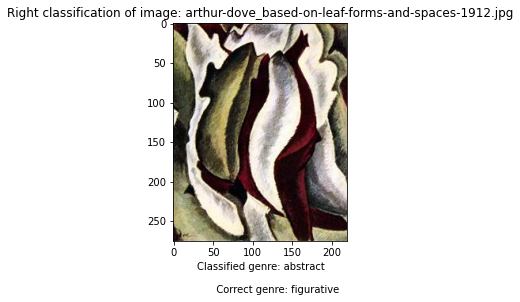

In [18]:
#show misclassified artwork
from PIL import Image
img_name = artwork2name.loc[mis_entry.iloc[0].artwork]["name"]
img = Image.open(fr'images-resized/{img_name}')
plt.imshow(img)
plt.title(f'Right classification of image: {img_name}')
plt.xlabel(f'''Classified genre: {genre2name.loc[mis_entry.iloc[0].predicted_genre]['name']}\n
           Correct genre: {genre2name.loc[mis_entry.iloc[0]['genre']]['name']}''')
plt.show()

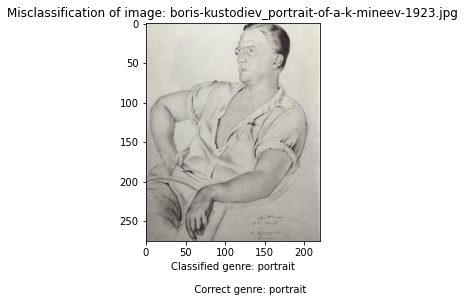

In [19]:
#correctly classified artwork
img_name = artwork2name.loc[right_entry.iloc[0].artwork]["name"]
img = Image.open(fr'images-resized/{img_name}')
plt.imshow(img)
plt.title(f'Misclassification of image: {img_name}')
plt.xlabel(f'''Classified genre: {genre2name.loc[right_entry.iloc[0].predicted_genre]['name']}\n
           Correct genre: {genre2name.loc[right_entry.iloc[0]['genre']]['name']}''')
plt.show()

As we can see, this domain is very tricky because the distance between genres (in this case) is not equal between each possible pair of genres (that is to say `figurative` **is really similar to** `abstract`)